In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
from scipy.io import arff
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os

Splitting the data to training and testing set

normal = normal_df.to_numpy()

In [2]:
normal_df = pd.read_csv("../data/ptbdb_normal.csv",header=None).iloc[:,:-1]

In [3]:
anomally_df = pd.read_csv("../data/ptbdb_abnormal.csv",header=None).iloc[:,:-1]
anomally_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
normal = normal_df.to_numpy()

In [5]:
anomaly = anomally_df.to_numpy()

In [6]:
X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, anomaly shape: {anomaly.shape}")

Train shape: (3439, 187), Test shape: (607, 187), anomaly shape: (10506, 187)


## 
# Building CNN Autoencoder Model

## About Autoencoders: Learning Efficient Data Representations

Autoencoders are a class of neural network architectures commonly used in unsupervised machine learning and deep learning tasks. Their primary purpose is to discover and learn efficient representations of data by encoding it into a lower-dimensional latent space and subsequently decoding it back to its original form. Autoencoders play a crucial role in various applications, such as dimensionality reduction, data denoising, anomaly detection, and generative modeling.

The core components of an autoencoder consist of an encoder and a decoder. The encoder maps input data to the latent space, while the decoder reconstructs the data from its encoded representation. During training, autoencoders aim to minimize the reconstruction error between the input and the decoded output, which results in the learning of meaningful data representations.

Autoencoders offer a versatile tool for feature extraction, data compression, and more, making them a valuable addition to the toolkit of data scientists and machine learning practitioners.


![Autoencoder](https://miro.medium.com/v2/resize:fit:640/format:webp/1*nqzWupxC60iAH2dYrFT78Q.png)

In [7]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[]

In [8]:
tf.keras.utils.set_random_seed(1024)

In [35]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim, **kwargs):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])
        # Previously, I was using UpSampling. I am trying Transposed Convolution this time around.
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(latent_dim, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_config(self):
        config = super(AutoEncoder, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "latent_dim": self.latent_dim,
        })
        return config
    
    # *** ADDED CLASSMETHOD TO ALLOW LOADING ***
    @classmethod
    def from_config(cls, config):
        return cls(**config)

input_dim = X_train.shape[-1]
latent_dim = 32

model = AutoEncoder(input_dim, latent_dim)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae")
model.summary()

Model: "auto_encoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 24, 32)         │        63,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,264 (247.12 KB)

 Trainable params: 62,688 (244.88 KB)

 Non-trainable params: 576 (2.25 KB)

In [36]:
epochs = 100
batch_size = 128
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.1971 - val_loss: 0.0938
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0882 - val_loss: 0.0905
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0881 - val_loss: 0.0815
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0975 - val_loss: 0.0977
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0911 - val_loss: 0.0857
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0859 - val_loss: 0.0848
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0852 - val_loss: 0.0856
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0846 - val_loss: 0.0849
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0844 - val_loss: 0.0842
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0844 - val_loss: 0.0848
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0843 - val_loss: 0.0851
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/st

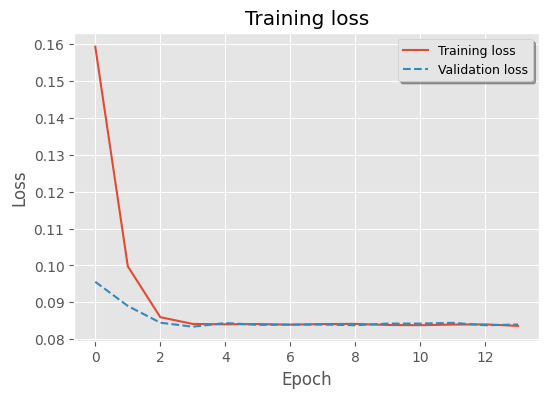

In [11]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [12]:
model.summary()

Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 24, 32)         │        63,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 187)            │       640,603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,109,299 (8.05 MB)

 Trainable params: 702,715 (2.68 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 1,405,432 (5.36 MB)

In [13]:
train_mae = model.evaluate(X_train, X_train, verbose=0)
test_mae = model.evaluate(X_test, X_test, verbose=0)
anomaly_mae = model.evaluate(anomally_df, anomally_df, verbose=0)

print("Training dataset error: ", train_mae)
print("Testing dataset error: ", test_mae)
print("Anormaly dataset error: ", anomaly_mae)

Training dataset error:  0.08342691510915756
Testing dataset error:  0.08268942683935165
Anormaly dataset error:  0.11958342790603638


In [14]:
def predict(model, X):
    pred = model.predict(X, verbose=False)
    loss = mae(pred, X)
    return pred, loss

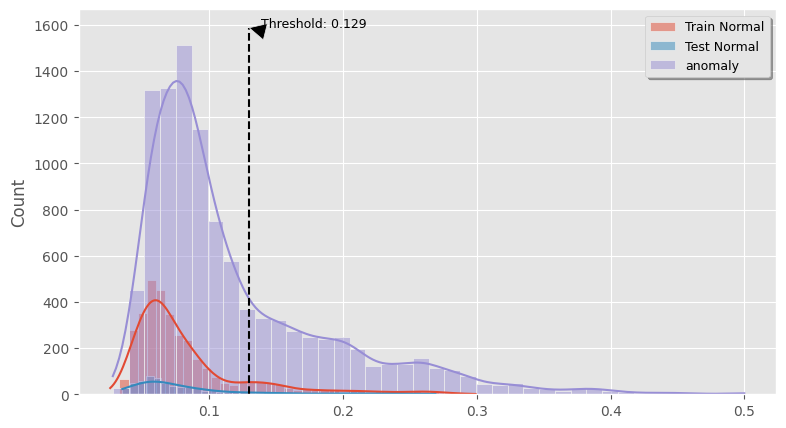

In [15]:
_, train_loss = predict(model, X_train)
_, test_loss = predict(model, X_test)
_, anomaly_loss = predict(model, anomaly)
threshold = np.mean(train_loss) + np.std(train_loss) # Setting threshold for distinguish normal data from anomalous data

bins = 40
plt.figure(figsize=(9, 5), dpi=100)
sns.histplot(np.clip(train_loss, 0, 0.5), bins=bins, kde=True, label="Train Normal")
sns.histplot(np.clip(test_loss, 0, 0.5), bins=bins, kde=True, label="Test Normal")
sns.histplot(np.clip(anomaly_loss, 0, 0.5), bins=bins, kde=True, label="anomaly")

ax = plt.gca()  # Get the current Axes
ylim = ax.get_ylim()
plt.vlines(threshold, 0, ylim[-1], color="k", ls="--")
plt.annotate(f"Threshold: {threshold:.3f}", xy=(threshold, ylim[-1]), xytext=(threshold+0.009, ylim[-1]),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=9)
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.show()

In [16]:
def plot_examples(model, data, ax, title):
    pred, loss = predict(model, data)
    ax.plot(data.flatten(), label="Actual")
    ax.plot(pred[0], label = "Predicted")
    ax.fill_between(range(1, 188), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True,
              facecolor="inherit", loc=1, fontsize=7)
#                bbox_to_anchor = (0, 0, 0.8, 0.25))

    ax.set_title(f"{title} (loss: {loss[0]:.3f})", fontsize=9.5)

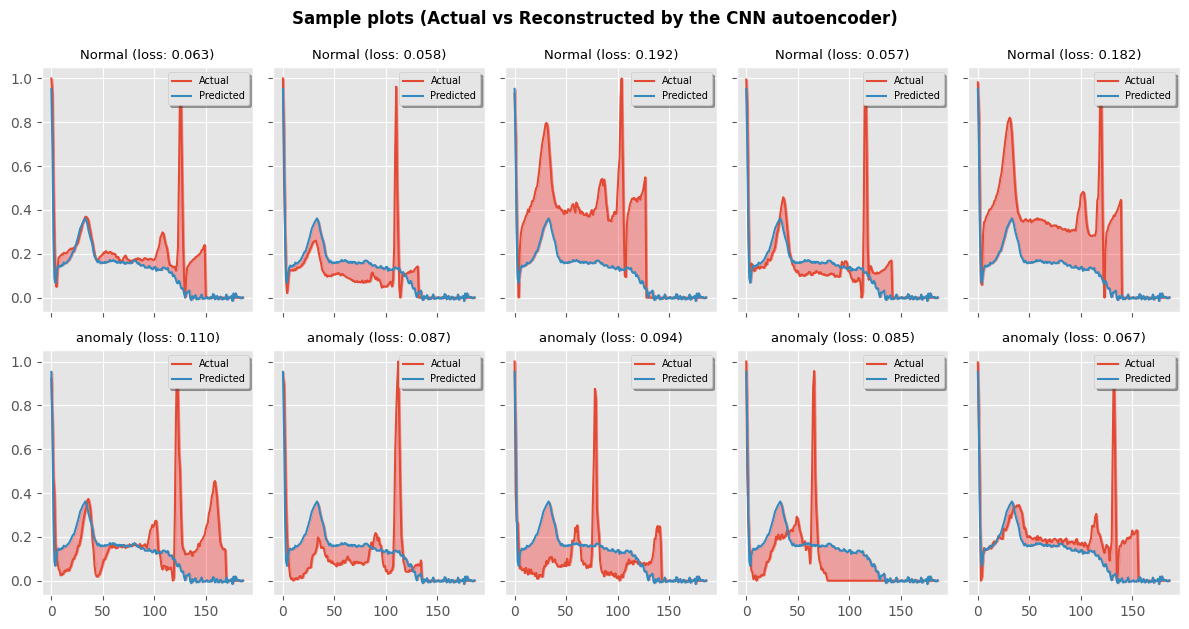

In [17]:
fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(12, 6), facecolor="w")
random_indexes = np.random.randint(0, len(X_train), size=5)

for i, idx in enumerate(random_indexes):
    data = X_train[[idx]]
    plot_examples(model, data, ax=axes[0, i], title="Normal")

for i, idx in enumerate(random_indexes):
    data = anomaly[[idx]]
    plot_examples(model, data, ax=axes[1, i], title="anomaly")

plt.tight_layout()
fig.suptitle("Sample plots (Actual vs Reconstructed by the CNN autoencoder)", y=1.04, weight="bold")
fig.savefig("autoencoder.png", dpi=500)
plt.show()

fig.savefig("autoencoder.png", dpi=500, transparent=False, facecolor="white")

In [38]:
# Assuming 'model' is your trained AutoEncoder instance

folder_name = '../model'
file_name = 'autoencoder_run_1.keras'
save_path = os.path.join(folder_name, file_name)

# Check if the directory exists, and create it if it does not
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Created directory: {folder_name}")
# Define the file path

# Use model.save()
model.save(save_path)

print(f"Model successfully saved to {save_path}")


Model successfully saved to ../model\autoencoder_run_1.keras


In [39]:
import tensorflow as tf
from tensorflow.keras import layers, Model
# Make sure your AutoEncoder class definition is available in this notebook/script

# Define the file path you saved to earlier
folder_name = '../model'
file_name ='autoencoder_run_1.keras'

load_path =os.path.join(folder_name, file_name)

# Use load_model and pass the custom_objects dictionary
loaded_model = tf.keras.models.load_model(
    load_path,
    custom_objects={'AutoEncoder': AutoEncoder}
)

# You can now use the loaded model just like the original one
loaded_model.summary()


Model: "auto_encoder_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 24, 32)         │        63,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 187)            │       640,603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,109,299 (8.05 MB)

 Trainable params: 702,715 (2.68 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 1,405,432 (5.36 MB)